In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
dv = np.load("data/cl_gg_input.npy")
ells = np.arange(2, len(dv) + 2)
zz, nz = np.load("data/dndz_input_z3_galaxy_field_lsstlike.npy")

In [ ]:
from classy import Class
lmax = len(dv) + 1
base_params = {
    # Saídas necessárias (CMB + LSS)
    'modes': 's',
    'output': 'tCl, pCl, lCl, mPk, nCl, dCl',
    'lensing': 'yes',
    'l_max_scalars': lmax,
    'l_max_lss': lmax,
    'number_count_contributions': 'density',

    # Energia escura via fld
    'Omega_Lambda': 0,
    'w0_fld': '-1.',
    'wa_fld': '0.0',

    # Espectro primordial (n_s fixo; sigma8 varia no loop)
    'n_s': 0.96,

    # Verbosidade e gauge
    'background_verbose': 0,
    'perturbations_verbose': 0,
    'gauge': 'Synchronous',

    # P(k) linear
    'z_pk': '1.0, 0.0',
    'P_k_max_h/Mpc': 10,
    'k_per_decade_for_pk': 30,
    'non linear': 'halofit',

    # Fundo
    'h': 0.673,
    'Omega_b': 0.03,

    # Seleção LSS (usando gaussian bin)
    'selection': 'gaussian',
    'selection_mean': '0.9', 
    'selection_width': '0.1',
    'selection_bias': '1.5'
}
Omega_nu_fid = 0.06/93.15/base_params['h']**2

def get_cl_gg(Omega_m, sigma_8):
    cosmo = Class()
    params = base_params.copy()
    params.update({
        'Omega_cdm': Omega_m - base_params['Omega_b'] - Omega_nu_fid, # TODO: include massive neutrinos
        'sigma8': sigma_8,
    })
    
    cosmo.set(params)
    cosmo.compute()
    
    cl_dens = cosmo.density_cl(lmax)
    Cl_gg = cl_dens['dd']['dens[1]-dens[1]']
    ell = np.arange(len(Cl_gg))

    return ell, np.asarray(Cl_gg), cosmo  # retorna o cosmo se quiser reaproveitar

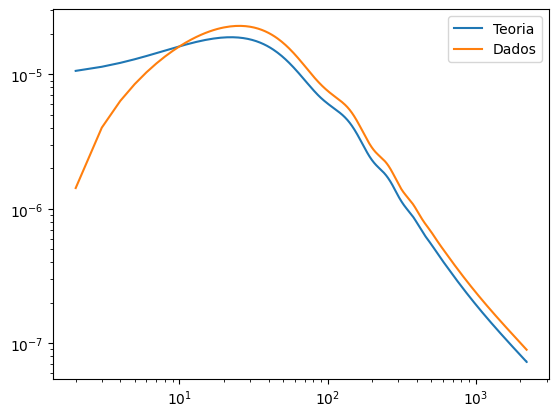

In [56]:
ell, cl_gg, _ = get_cl_gg(0.18, 0.840)
plt.loglog(ells, cl_gg[2:], label="Teoria")
plt.loglog(ells, dv,        label="Dados")
plt.legend()
plt.savefig("comparacao_cl_gg.pdf")